In [1]:
import pandas as pd 
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as pyplot

C:\Users\krish\AppData\Local\Temp\ipykernel_8500\2524047752.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Data Preprocessing

In [2]:
data = pd.read_csv('payment-practices.csv')

In [3]:
data.head()

,Report Id,Start date,End date,Filing date,Company,Company number,Payments made in the reporting period,Average time to pay,% Invoices paid within 30 days,% Invoices paid between 31 and 60 days,...,Longest standard payment period,Maximum contractual payment period,Payment terms have changed,Suppliers notified of changes,Participates in payment codes,E-Invoicing offered,Supply-chain financing offered,Policy covers charges for remaining on supplier list,Charges have been made for remaining on supplier list,URL
0,2,29-04-2017,28-10-2017,07-11-2017,MEDTRONIC LIMITED,1070807,NaN,25.0,77.0,20.0,...,60.0,60.0,False,NaN,False,True,False,False,False,https://check-payment-practices.service.gov.uk...
1,3,01-05-2017,31-10-2017,08-11-2017,SEBDEN STEEL SERVICE CENTRES LIMITED,2553464,NaN,69.0,7.0,28.0,...,NaN,75.0,False,NaN,False,False,False,False,False,https://check-payment-practices.service.gov.uk...
2,4,15-04-2017,14-10-2017,08-11-2017,GREENERGY FLEXIGRID LIMITED,7581532,NaN,21.0,89.0,9.0,...,30.0,30.0,False,NaN,False,False,False,True,True,https://check-payment-practices.service.gov.uk...
3,5,15-04-2017,14-10-2017,08-11-2017,GREENERGY FUELS LIMITED,4058825,NaN,14.0,90.0,8.0,...,30.0,30.0,False,NaN,False,False,False,True,True,https://check-payment-practices.service.gov.uk...
4,6,15-04-2017,14-10-2017,08-11-2017,GREENERGY INTERNATIONAL LIMITED,2809935,NaN,15.0,96.0,2.0,...,30.0,30.0,False,NaN,False,False,False,True,False,https://check-payment-practices.service.gov.uk...


In [4]:
data.describe()

,Report Id,Average time to pay,% Invoices paid within 30 days,% Invoices paid between 31 and 60 days,% Invoices paid later than 60 days,% Invoices not paid within agreed terms,Shortest (or only) standard payment period,Longest standard payment period,Maximum contractual payment period
count,77681.000000,70822.000000,70822.000000,70822.000000,70822.000000,70973.000000,70973.000000,47119.000000,70973.000000
mean,39683.118935,36.681300,55.978029,30.119553,13.896134,27.819875,20.522241,70.820073,73.439266
std,22812.737305,23.010175,28.461688,20.590250,16.762054,23.697790,21.603915,46.305430,86.101648
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,19956.000000,24.000000,32.000000,13.000000,3.000000,9.000000,1.000000,60.000000,45.000000
50%,39765.000000,34.000000,58.000000,28.000000,7.000000,22.000000,14.000000,60.000000,60.000000
75%,59430.000000,46.000000,81.000000,45.000000,18.000000,41.000000,30.000000,90.000000,90.000000
max,79107.000000,1120.000000,100.000000,100.000000,100.000000,100.000000,1000.000000,1264.000000,5475.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77681 entries, 0 to 77680
Data columns (total 23 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Report Id                                              77681 non-null  int64  
 1   Start date                                             77681 non-null  object 
 2   End date                                               77681 non-null  object 
 3   Filing date                                            77681 non-null  object 
 4   Company                                                77681 non-null  object 
 5   Company number                                         77681 non-null  object 
 6   Payments made in the reporting period                  63008 non-null  object 
 7   Average time to pay                                    70822 non-null  float64
 8   % Invoices paid within 30 days                

In [6]:
data.drop(columns=['Report Id','Start date', 'End date', 'Filing date', 'Company',
       'Company number','URL'],axis=1,inplace=True)

In [7]:
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,14673,18.888789
Average time to pay,6859,8.829701
% Invoices paid within 30 days,6859,8.829701
% Invoices paid between 31 and 60 days,6859,8.829701
% Invoices paid later than 60 days,6859,8.829701
% Invoices not paid within agreed terms,6708,8.635316
Shortest (or only) standard payment period,6708,8.635316
Longest standard payment period,30562,39.342954
Maximum contractual payment period,6708,8.635316
Payment terms have changed,6708,8.635316


In [8]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = ['Payments made in the reporting period', 'Payment_terms_have_changed', 'Suppliers_notified_of_changes','Participates in payment codes' , 'E-Invoicing_offered', 'Supply-chain_financing_offered','Policy covers charges for remaining on supplier list','Charges have been made for remaining on supplier list']
data = data.astype({'Participates in payment codes':'bool'})

In [9]:
for var in numerical_cols:
    data[var].fillna(data[var].mean(), inplace=True)

C:\Users\krish\AppData\Local\Temp\ipykernel_8500\797122091.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[var].fillna(data[var].mean(), inplace=True)


In [10]:
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,14673,18.888789
Average time to pay,0,0.000000
% Invoices paid within 30 days,0,0.000000
% Invoices paid between 31 and 60 days,0,0.000000
% Invoices paid later than 60 days,0,0.000000
% Invoices not paid within agreed terms,0,0.000000
Shortest (or only) standard payment period,0,0.000000
Longest standard payment period,0,0.000000
Maximum contractual payment period,0,0.000000
Payment terms have changed,6708,8.635316


In [11]:
missing_data_cols = ['Payments made in the reporting period','Payment terms have changed', 'Suppliers notified of changes', 'E-Invoicing offered', 'Supply-chain financing offered','Policy covers charges for remaining on supplier list','Charges have been made for remaining on supplier list']

In [12]:
for i in missing_data_cols:
    data_complete = data.drop(columns=missing_data_cols,axis=1)
    data_complete[i] = data[i]
    data_incomplete = data_complete[data_complete.isnull().any(axis=1)]
    data_complete.dropna(inplace=True)
    data_complete = data_complete.astype({i:'bool'})
    X_train = data_complete.drop(columns=[i])
    y_train = data_complete[i]
    model = LogisticRegression()
    model.fit(X_train, y_train)
    predicted_values = model.predict(data_incomplete.drop(columns=[i]))
    data_incomplete[i] = predicted_values
    data.update(data_incomplete)

C:\Users\krish\AppData\Local\Temp\ipykernel_8500\3466573870.py:13: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.update(data_incomplete)
C:\Users\krish\AppData\Local\Temp\ipykernel_8500\3466573870.py:13: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.update(data_incomplete)
C:\Users\kri

In [13]:
print(data.isnull().sum())

Payments made in the reporting period                    0
Average time to pay                                      0
% Invoices paid within 30 days                           0
% Invoices paid between 31 and 60 days                   0
% Invoices paid later than 60 days                       0
% Invoices not paid within agreed terms                  0
Shortest (or only) standard payment period               0
Longest standard payment period                          0
Maximum contractual payment period                       0
Payment terms have changed                               0
Suppliers notified of changes                            0
Participates in payment codes                            0
E-Invoicing offered                                      0
Supply-chain financing offered                           0
Policy covers charges for remaining on supplier list     0
Charges have been made for remaining on supplier list    0
dtype: int64


<Axes: >

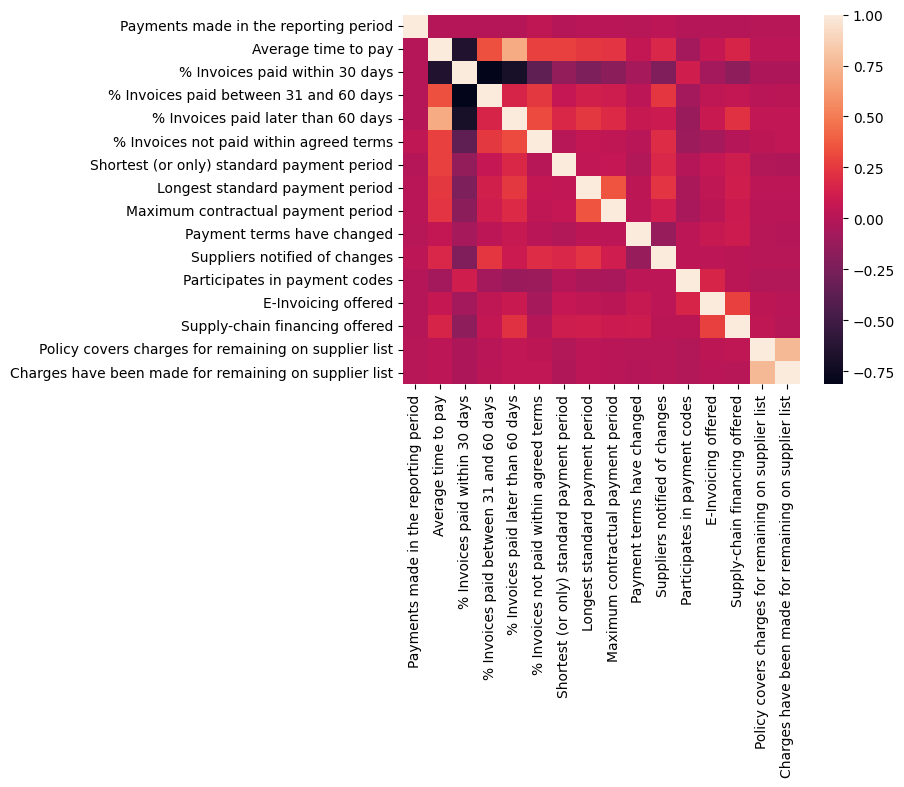

In [14]:
import seaborn as sns 
sns.heatmap(data.corr())